# Image Colourization using GANs

In [54]:
# Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from tqdm import tqdm
import time

In [55]:
# Download Dataset
import kagglehub

path = kagglehub.dataset_download("rhtsingh/google-universal-image-embeddings-128x128") # Download latest version

path += "/128x128"

print("Path to dataset files:", path)

# path = "/dataset" # Paste path to dataset containing images in folders

Path to dataset files: /kaggle/input/google-universal-image-embeddings-128x128/128x128


In [56]:
# ========== LAB COLOR UTILITIES ==========
from skimage import color

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

def lab_to_rgb(L, ab):
    L = to_numpy(L)
    ab = to_numpy(ab)
    if L.ndim == 3 and L.shape[0] == 1:
        L = L[0]
    if ab.shape[0] == 2:
        ab = ab.transpose(1, 2, 0)
    # Make sure both L and ab are NumPy and of the same dtype
    L = np.array(L, dtype=np.float32)
    ab = np.array(ab, dtype=np.float32)
    lab = np.zeros((L.shape[0], L.shape[1], 3), dtype=np.float32)
    lab[:, :, 0] = L * 100
    lab[:, :, 1:] = ab * 128
    rgb = color.lab2rgb(lab)
    rgb = np.clip(rgb, 0, 1)
    return rgb

def rgb_to_lab(img):
    # Ensure the input is a NumPy array before passing to skimage
    if isinstance(img, torch.Tensor):
        img = img.numpy()
    lab = color.rgb2lab(img)
    L = lab[:, :, 0] / 100.0
    ab = lab[:, :, 1:] / 128.0
    return torch.tensor(L).unsqueeze(0), torch.tensor(ab).permute(2, 0, 1)


In [57]:
# ========== Dataset Prepartion ==========
class LABColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.image_paths = []
        for class_folder in os.listdir(root_dir):
            class_folder_path = os.path.join(root_dir, class_folder)
            if os.path.isdir(class_folder_path):
                for img_name in os.listdir(class_folder_path):
                    self.image_paths.append(os.path.join(class_folder_path, img_name))
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        img = self.transform(img)  # Resize and convert to tensor
        img_np = img.permute(1, 2, 0).numpy()  # (H, W, C)

        from skimage import color
        lab = color.rgb2lab(img_np).astype("float32")
        L = lab[:, :, 0] / 100.0
        ab = lab[:, :, 1:] / 128.0

        L = torch.from_numpy(L).unsqueeze(0)        # (1, H, W)
        ab = torch.from_numpy(ab).permute(2, 0, 1)  # (2, H, W)
        return L, ab

    def __len__(self):
        return len(self.image_paths)


In [58]:
# Dataset and Split
transform_resize = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = LABColorizationDataset(
    root_dir=path,
    transform=transform_resize
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True, num_workers=6)
# test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, pin_memory=True, num_workers=6)

# For A100 GPU
train_loader = DataLoader(
    train_ds,
    batch_size=256,
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [59]:
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of test samples: {len(test_ds)}")

Number of training samples: 119275
Number of test samples: 13253


### Define GAN Architecture

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_ch, out_ch): return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU())

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2, 2)

        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec1 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec3 = CBR(128, 64)

        self.final = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d1 = self.up1(e4)
        d1 = self.dec1(torch.cat([d1, e3], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d3 = self.up3(d2)
        d3 = self.dec3(torch.cat([d3, e1], dim=1))

        return torch.tanh(self.final(d3))

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_ch, out_ch, norm=True):
            layers = [nn.Conv2d(in_ch, out_ch, 4, stride=2, padding=1)]
            if norm:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(3, 64, norm=False),
            block(64, 128),
            block(128, 256),
            block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)  # Output: PatchGAN style
        )

    def forward(self, L, ab):
        x = torch.cat([L, ab], dim=1)  # input is (L + ab) = 3 channels
        return self.model(x)


In [61]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

Using device: cuda


### Loss and Training Loop

In [62]:
# Visualize predictions
def visualize_predictions(model, test_dataset, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        samples = random.sample(list(test_dataset), num_samples)
        plt.figure(figsize=(15, 9))
        for i in range(num_samples):
            L = samples[i][0].unsqueeze(0).to(device)  # shape: (1, 1, H, W)
            true_ab = samples[i][1].to(device)         # shape: (2, H, W)

            pred_ab = model(L).squeeze(0).cpu()         # (2, H, W)
            L_cpu = L.cpu().squeeze(0).squeeze(0)       # (H, W)

            recon_true = lab_to_rgb(L_cpu, true_ab.cpu())
            recon_pred = lab_to_rgb(L_cpu, pred_ab)

            # Plot grayscale input
            plt.subplot(3, num_samples, i + 1)
            plt.imshow(L_cpu, cmap='gray')
            plt.axis('off')
            plt.title("Grayscale")

            # Plot original color image
            plt.subplot(3, num_samples, i + 1 + num_samples)
            plt.imshow(recon_true)
            plt.axis('off')
            plt.title("Original")

            # Plot predicted image
            plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
            plt.imshow(recon_pred)
            plt.axis('off')
            plt.title("Colorized")

        plt.tight_layout()
        plt.show()


In [ ]:
# Hyperparameters

G = GeneratorUNet().to(device)
D = Discriminator().to(device)

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

epochs = 50

Epoch 1/20: 100%|██████████| 466/466 [02:39<00:00,  2.93it/s, D_Loss=0.263, G_Loss=15.5]


[Epoch 1] G_Loss: 14.8233, D_Loss: 0.5315


Epoch 2/20: 100%|██████████| 466/466 [02:36<00:00,  2.97it/s, D_Loss=0.906, G_Loss=11.8]


[Epoch 2] G_Loss: 11.8753, D_Loss: 1.0792


Epoch 3/20: 100%|██████████| 466/466 [02:37<00:00,  2.97it/s, D_Loss=1.41, G_Loss=12.9]


[Epoch 3] G_Loss: 12.4889, D_Loss: 1.0379


Epoch 4/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=1.26, G_Loss=12.1]


[Epoch 4] G_Loss: 11.9715, D_Loss: 1.1265


Epoch 5/20: 100%|██████████| 466/466 [02:37<00:00,  2.97it/s, D_Loss=0.665, G_Loss=13.1]


[Epoch 5] G_Loss: 12.3639, D_Loss: 1.0117


Epoch 6/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=1.2, G_Loss=12]


[Epoch 6] G_Loss: 12.2177, D_Loss: 1.0739


Epoch 7/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=0.148, G_Loss=14.1]


[Epoch 7] G_Loss: 13.1309, D_Loss: 0.6782


Epoch 8/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=1.17, G_Loss=12.2]


[Epoch 8] G_Loss: 12.1584, D_Loss: 1.0183


Epoch 9/20: 100%|██████████| 466/466 [02:37<00:00,  2.97it/s, D_Loss=0.597, G_Loss=12.8]


[Epoch 9] G_Loss: 11.8802, D_Loss: 1.0482


Epoch 10/20: 100%|██████████| 466/466 [02:37<00:00,  2.97it/s, D_Loss=0.716, G_Loss=12.7]


Visualizing predictions at epoch 10


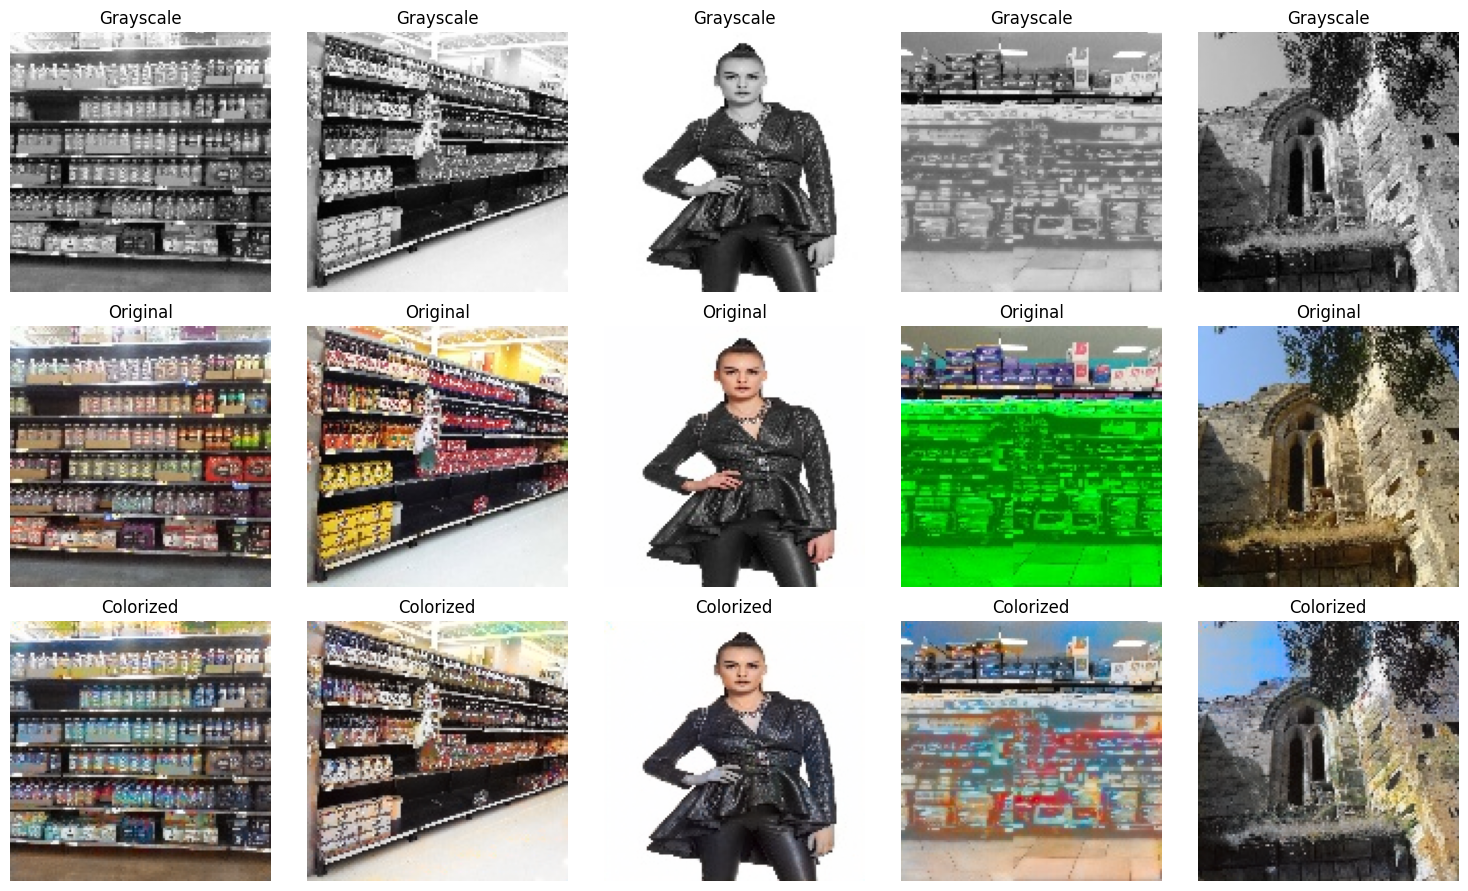

[Epoch 10] G_Loss: 12.1075, D_Loss: 0.9726


Epoch 11/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=0.839, G_Loss=12]


[Epoch 11] G_Loss: 12.3694, D_Loss: 0.8961


Epoch 12/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=0.787, G_Loss=12.2]


[Epoch 12] G_Loss: 12.2350, D_Loss: 0.9135


Epoch 13/20: 100%|██████████| 466/466 [02:37<00:00,  2.97it/s, D_Loss=0.901, G_Loss=13.4]


[Epoch 13] G_Loss: 12.1856, D_Loss: 0.9082


Epoch 14/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=0.861, G_Loss=13]


[Epoch 14] G_Loss: 12.2936, D_Loss: 0.8654


Epoch 15/20: 100%|██████████| 466/466 [02:37<00:00,  2.97it/s, D_Loss=1.14, G_Loss=12]


[Epoch 15] G_Loss: 12.2967, D_Loss: 0.8625


Epoch 16/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=1.17, G_Loss=11.6]


[Epoch 16] G_Loss: 12.4153, D_Loss: 0.8298


Epoch 17/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=1, G_Loss=11.9]


[Epoch 17] G_Loss: 12.3894, D_Loss: 0.8338


Epoch 18/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=0.86, G_Loss=13.4]


[Epoch 18] G_Loss: 12.4042, D_Loss: 0.8079


Epoch 19/20: 100%|██████████| 466/466 [02:37<00:00,  2.96it/s, D_Loss=0.777, G_Loss=13.6]


[Epoch 19] G_Loss: 12.5342, D_Loss: 0.7774


Epoch 20/20: 100%|██████████| 466/466 [02:37<00:00,  2.97it/s, D_Loss=0.635, G_Loss=12.4]


Visualizing predictions at epoch 20


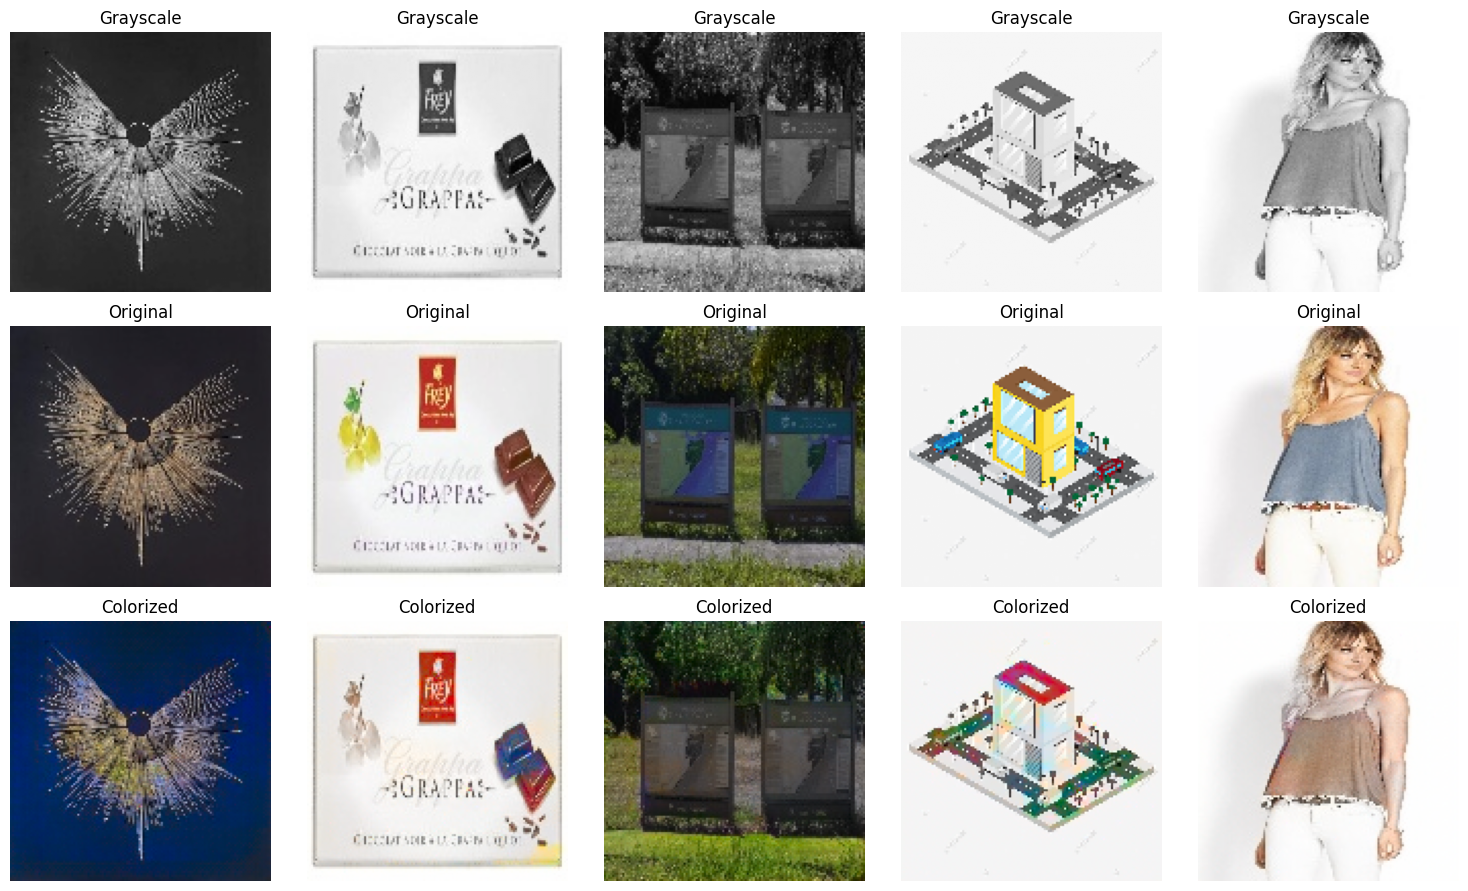

[Epoch 20] G_Loss: 12.5835, D_Loss: 0.7805


In [64]:
# Training Loop

g_losses = []
d_losses = []

for epoch in range(epochs):
    G.train()
    D.train()

    total_g_loss, total_d_loss = 0.0, 0.0
    g_loss_running, d_loss_running = 0.0, 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for L, ab in loop:
        L, ab = L.to(device), ab.to(device)
        real_labels = torch.ones((L.size(0), 1, 14, 14), device=device)
        fake_labels = torch.zeros((L.size(0), 1, 14, 14), device=device)

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        pred_ab = G(L).detach()
        real_output = D(L, ab)
        fake_output = D(L, pred_ab)

        # Match label shapes to output shapes
        real_labels = torch.ones_like(real_output)
        fake_labels = torch.zeros_like(fake_output)

        d_loss = criterion_GAN(real_output, real_labels) + criterion_GAN(fake_output, fake_labels)
        d_loss.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        optimizer_G.zero_grad()
        fake_ab = G(L)
        output = D(L, fake_ab)
        g_adv_loss = criterion_GAN(output, real_labels)
        g_l1_loss = criterion_L1(fake_ab, ab)
        g_loss = g_adv_loss + 150 * g_l1_loss
        g_loss.backward()
        optimizer_G.step()

        g_loss_running += g_loss.item()
        d_loss_running += d_loss.item()

        loop.set_postfix(G_Loss=g_loss.item(), D_Loss=d_loss.item())

    g_losses.append(g_loss_running/len(train_loader))
    d_losses.append(d_loss_running/len(train_loader))

    if (epoch + 1) % 10 == 0:
      print(f"Visualizing predictions at epoch {epoch+1}")
      visualize_predictions(G, test_ds, device)

    print(f"[Epoch {epoch+1}] G_Loss: {g_loss_running/len(train_loader):.4f}, D_Loss: {d_loss_running/len(train_loader):.4f}")

    torch.save(G.state_dict(), "color_GAN_generator.pth")


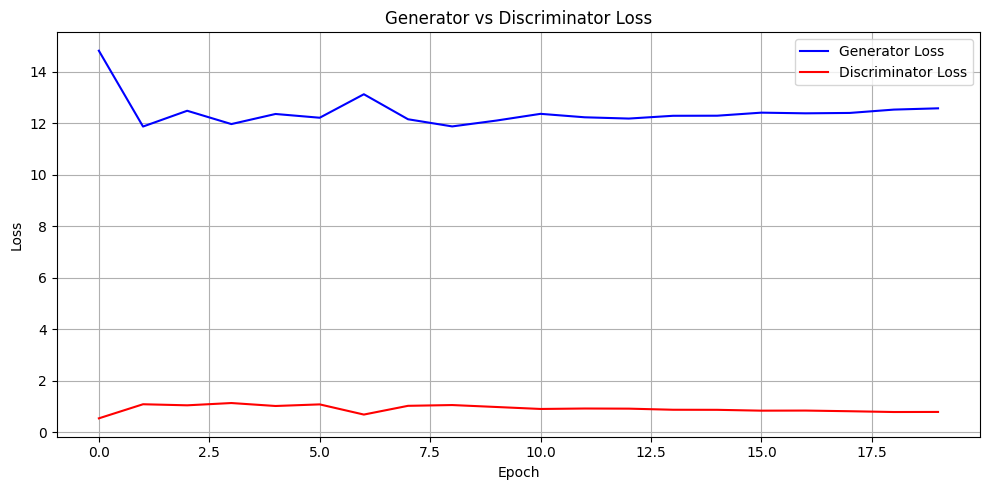

In [65]:
# Plot Generator and Discriminator Loss

plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator vs Discriminator Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1801284097.py:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  rgb = color.lab2rgb(lab)


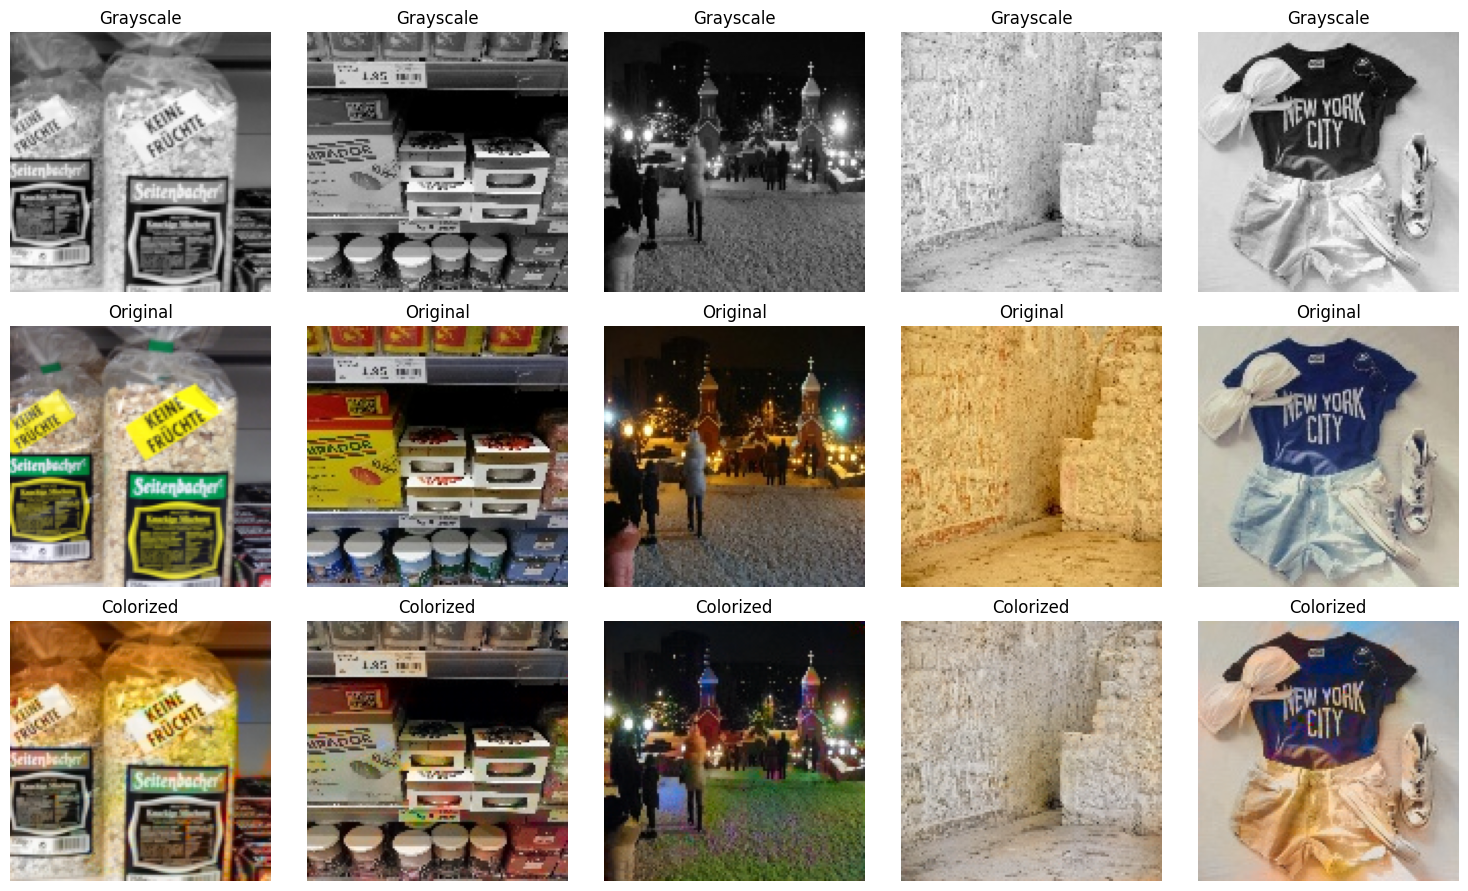

In [67]:
# Final Visualization

G.load_state_dict(torch.load("color_GAN_generator.pth"))

visualize_predictions(G, test_ds, device, num_samples=5)

